In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests
import os
import random
import warnings
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [3]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]
df = df[df['수율'].between(60, 100)]

df.to_csv('For_my_use_1.csv', index=False)

# Make sure the date column is in datetime format
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

In [4]:
# Target variable
target = 'CC_P'

'''
# Outlier removal
if 'Precipitation (mm)' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Precipitation (mm)'] <= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {'Precipitation (mm)'} > 10.")
else:
    print(f"Warning: '{'Precipitation (mm)'}' column not found.")
'''
# chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
# df['chin_total'] = df[chin_variables].sum(axis=1)

scraps_col = [
    '스크랩_S01_친',
    '스크랩_S01_자',
    # '스크랩_S01_손', # for GPR
    'A부스러기　친',
    'A부스러기 자',
    'A부스러기 손',
    # '친단　친', # for GPR
    '친단　자',
    '친단　손',
    '와셔 친',
    # '와셔 자', # for GPR
    # '와셔 손', # for GPR
    'B부스러기　친',
    'B부스러기 자',
    'B부스러기 손',
    '선다라이 친',
    # '선다라이 자', # for GPR
    # '선다라이 손', # for GPR
    # '류선 친', # for GPR
    '류선 자',
    # '류선 손', # for GPR
    '시타마와리(자동차 부품으로 예상됨)　친',
    # '시타마와리(자동차 부품으로 예상됨)　자', # for GPR
    # '시타마와리(자동차 부품으로 예상됨)　손', # for GPR
    '엔진 친',
    # '엔진 자',
    # '엔진 손',
    '슈레더 친',
    '슈레더 자',
    '슈레더 손',
    'C프레스 친',
    'C프레스 자',
    # 'C프레스 손', # for GPR
    # '다라이가루 친', # for GPR
    '다라이가루 자',
    '다라이가루 손',
    '강류 친',
    # '강류 자', # for GPR
    # '강류 손', # for GPR
    '타이어 친',
    # '타이어　자', # for GPR
    # '타이어　손', # for GPR
    '주물　친',
    # '주물　자', # for GPR
    # '주물　손', # for GPR
    # '알루미더스트　친', # for GPR
    # '알루미더스트　자', # for GPR
    # '알루미더스트　손', # for GPR
    # 'AB프레스　친', # for GPR
    # 'AB프레스　자', # for GPR
    # 'AB프레스　손', # for GPR
    # 'Mn강　친', # for GPR
    # 'Mn강　자', # for GPR
    # 'Mn강　손', # for GPR
    # '캔버서　친', # for GPR
    # '캔버서　자', # for GPR
    # '캔버서　손', # for GPR
    # '페인트캔　친', # for GPR
    # '페인트캔　자', # for GPR
    # '페인트캔　손', # for GPR
    'V프레스　친',
    # 'V프레스　자', # for GPR
    # 'V프레스　손', # for GPR
    # '캔프레스　친', # for GPR
    '캔프레스　자',
    # '캔프레스　손', # for GPR
    '빌렛부스러기　친',
    # '빌렛부스러기 자', # for GPR
    # '빌렛부스러기 손', # for GPR
    # 'SC（레들）바탕쇠　친', # for GPR
    'SC（레들）바탕쇠　자',
    # 'SC（레들）바탕쇠　손', # for GPR
    # 'EF바탕쇠　친', # for GPR
    'EF바탕쇠　자',
    # 'EF바탕쇠　손', # for GPR
    # 'CC바탕쇠　친', # for GPR
    # 'CC바탕쇠　자', # for GPR
    # 'CC바탕쇠　손', # for GPR
    '정비부스러기　친',
    # '정비부스러기　자', # for GPR
    # '정비부스러기　손', # for GPR
]

chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
ja_variables = [col for col in df.columns if '자' in col]
son_variables = [col for col in df.columns if '손' in col]

scraps = chin_variables + ja_variables + son_variables

input_variables = ['MD_C', 'MD_Mn', 'MD_Cr', 'MD_Si', 'MD_S', '장입량t']

unusable_variables = ['TAP-TAP', '온도', 'CaO', '사용전력량', 'O2사용량_합계']

other_variables = ['연회회수']

# variables = []

unusable_variables = [
     target
]

# If you have metadata columns like 날짜 or index, exclude them too
meta_columns = ['날짜', '강번', '출강개시일시', '강종명', 'wet_condition_last24', 'wet_condition_last48', 'wet_condition_last72', 'wet_condition_last24_lag24', 'wet_condition_last24_lag48']  # add more if needed
exclude_columns = set(unusable_variables + meta_columns)

variables = scraps_col + input_variables

# Create input X and output y
X = df[variables].fillna(0)

# Keep only columns that are fully numeric (i.e., all values can be converted to float)
X = X.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric to NaN
X = X.dropna(axis=1, how='any')              # Drop columns with any NaNs (i.e., had non-numeric values)
X = X.replace([np.inf, -np.inf], np.nan)

y = df[target]

# Sequential train-test split
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index].fillna(0)
X_test = X.iloc[split_index:].fillna(0)

# Convert all columns to numeric again and ensure type float64
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Drop any remaining columns with NaNs or invalid types
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
X_test = X_test[X_train.columns]  # Keep only matching columns

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [5]:
# --- Model training and evaluation functions ---

def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # --- Calculate Metrics ---
    # Train
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, train_pred)
    mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100
    r2_train = r2_score(y_train, train_pred)

    # Test
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, test_pred)
    mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
    r2_test = r2_score(y_test, test_pred)

    # --- Print Metrics ---
    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")
    
    # Plot
    train_df = df[['강번']].loc[X_train.index].copy()
    train_df['Actual'] = y_train.values
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['강번']].loc[X_test.index].copy()
    test_df['Actual'] = y_test.values
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('강번').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test-only plot
    test_df = test_df.sort_values('강번').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return test_df


--- Linear Regression Model Evaluation ---
Linear Regression Train Scores:
  MSE:  7.98
  RMSE: 2.82
  MAE:  2.17
  MAPE: 7.26%
  R²:   0.235

Linear Regression Test Scores:
  MSE:  6.11
  RMSE: 2.47
  MAE:  1.89
  MAPE: 6.41%
  R²:   0.026


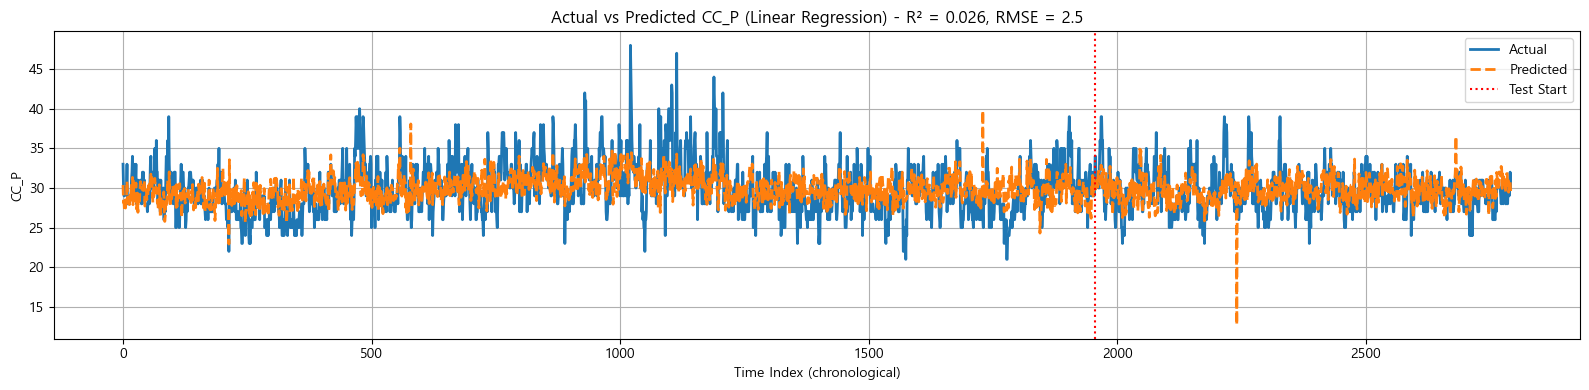

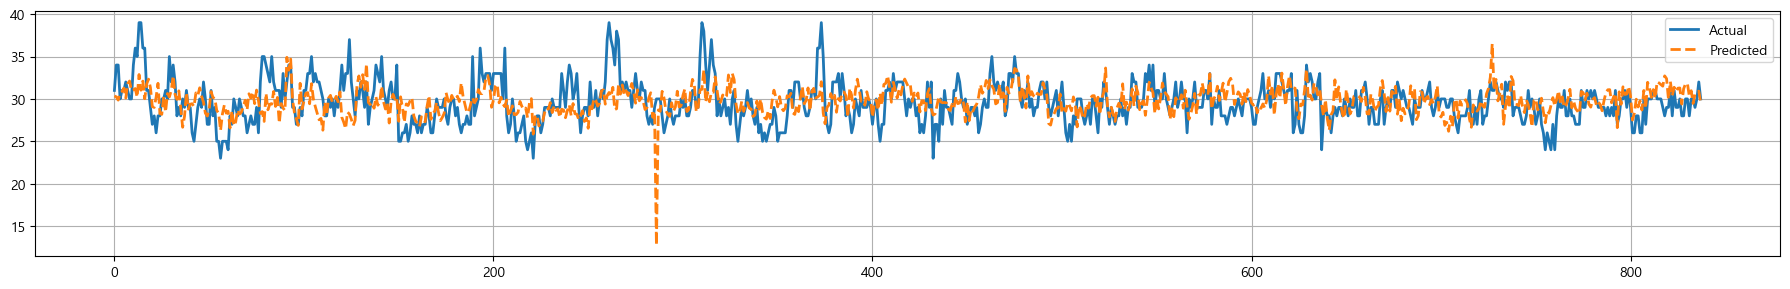


--- SHAP Summary: Linear Regression ---


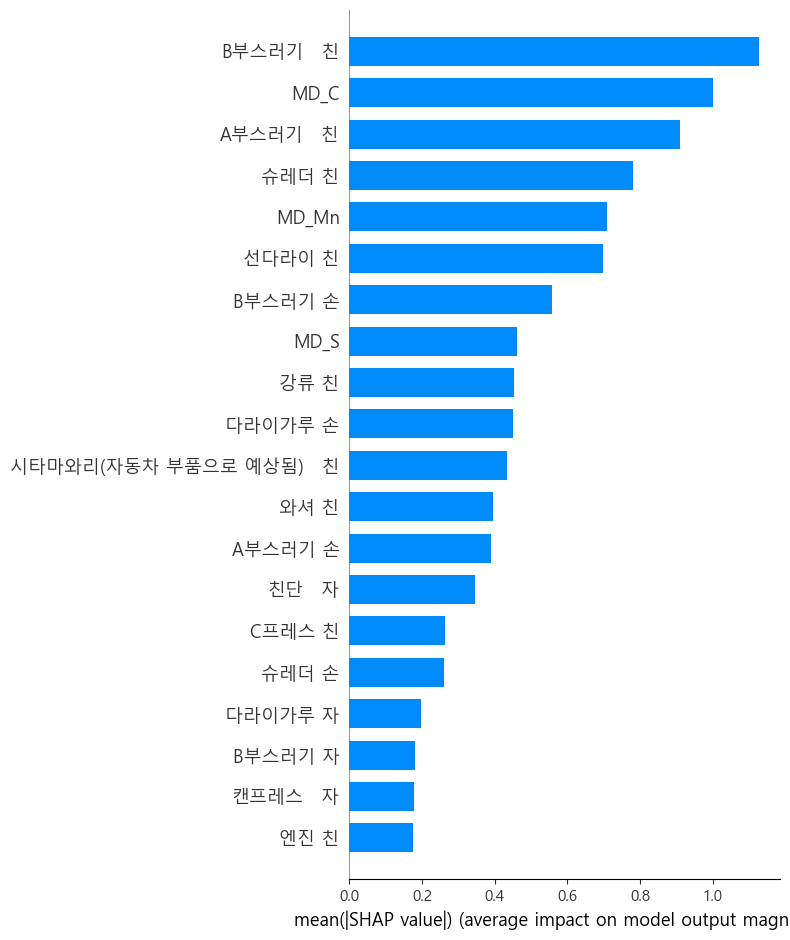

In [ ]:
# --- Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_model, X_train, y_train, X_test, y_test, df)

# SHAP for linear model
explainer_lin = shap.Explainer(lin_model, X_train)
shap_values_lin = explainer_lin(X_train)

# Global importance plot
print("\n--- SHAP Summary: Linear Regression ---")
shap.summary_plot(shap_values_lin, X_train, plot_type="bar")


--- XGBoost Model Evaluation ---
XGBoost Train Scores:
  MSE:  4.81
  RMSE: 2.19
  MAE:  1.68
  MAPE: 5.60%
  R²:   0.539

XGBoost Test Scores:
  MSE:  5.60
  RMSE: 2.37
  MAE:  1.88
  MAPE: 6.44%
  R²:   0.107


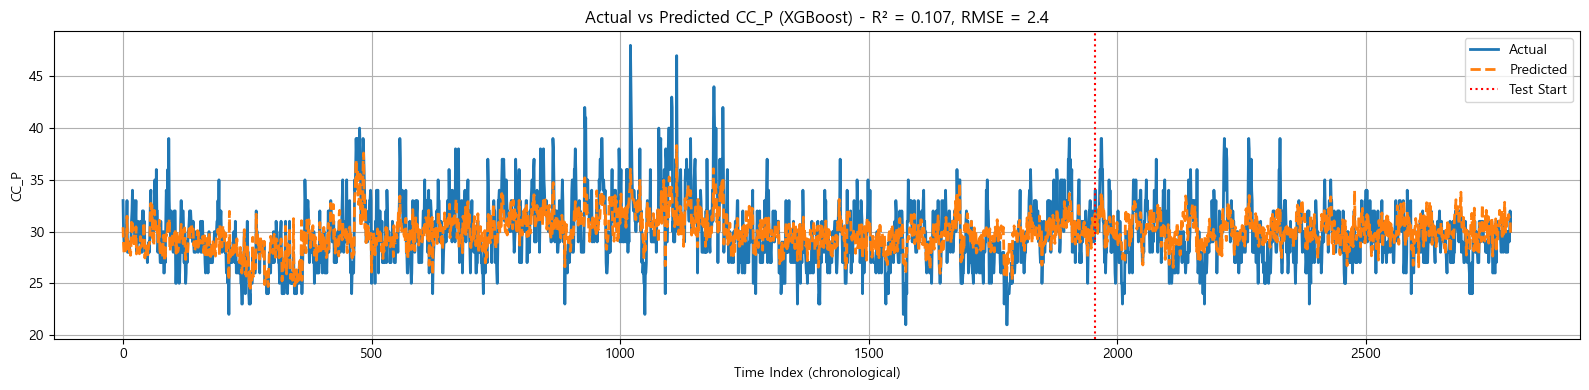

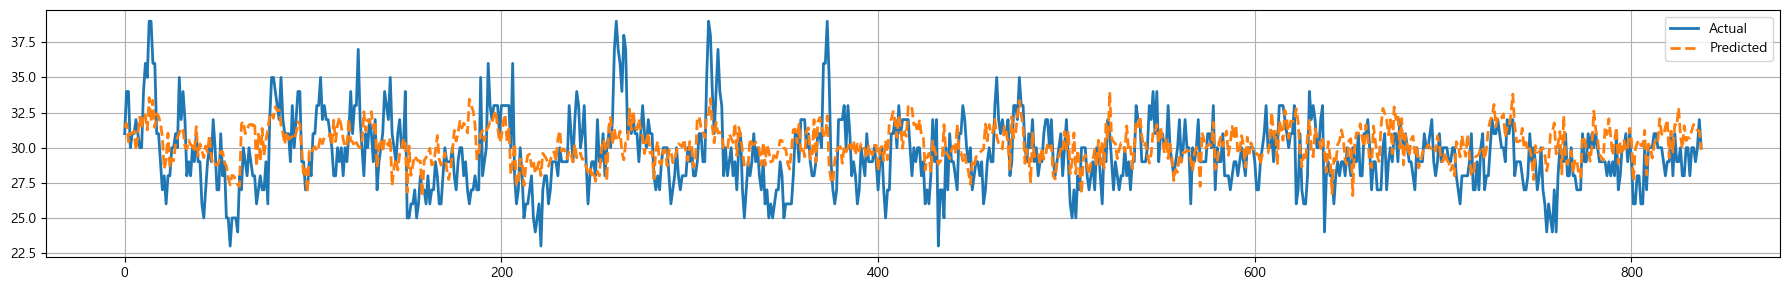

 95%|=================== | 1864/1955 [00:20<00:00]       


--- SHAP Summary: XGBoost ---


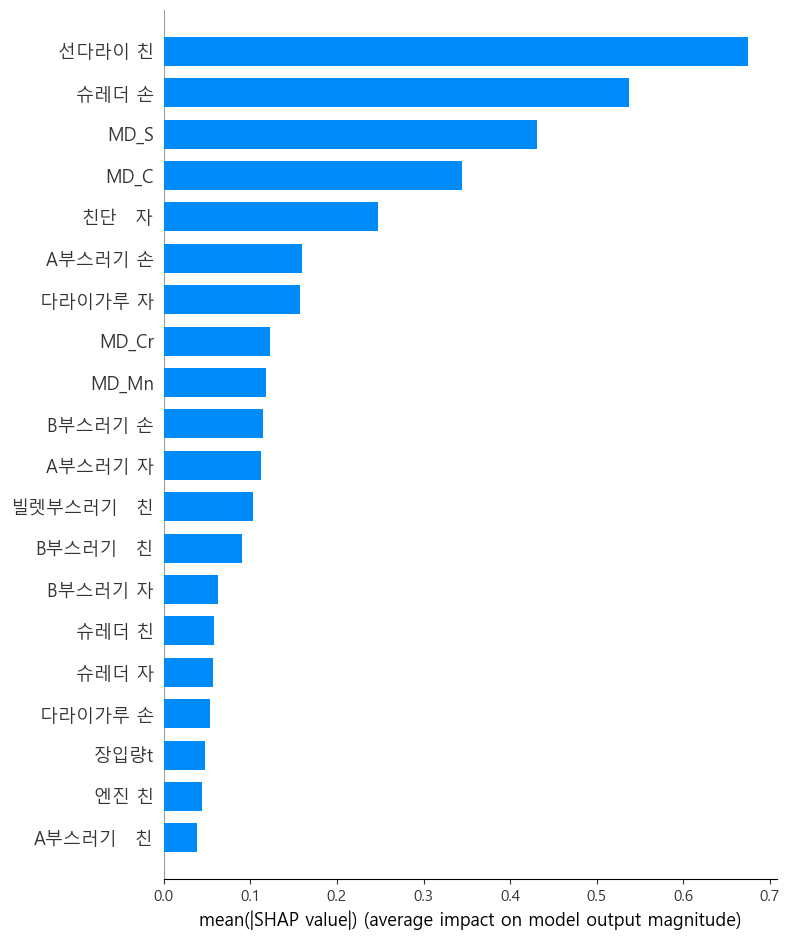

In [ ]:
# --- XGBoost ---
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test, df)

# SHAP for XGBoost (TreeExplainer is fast and accurate)
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_train)

# Global importance plot
print("\n--- SHAP Summary: XGBoost ---")
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")




--- Random Forest Model Evaluation ---
Random Forest Train Scores:
  MSE:  0.92
  RMSE: 0.96
  MAE:  0.72
  MAPE: 2.41%
  R²:   0.912

Random Forest Test Scores:
  MSE:  5.94
  RMSE: 2.44
  MAE:  1.93
  MAPE: 6.64%
  R²:   0.053


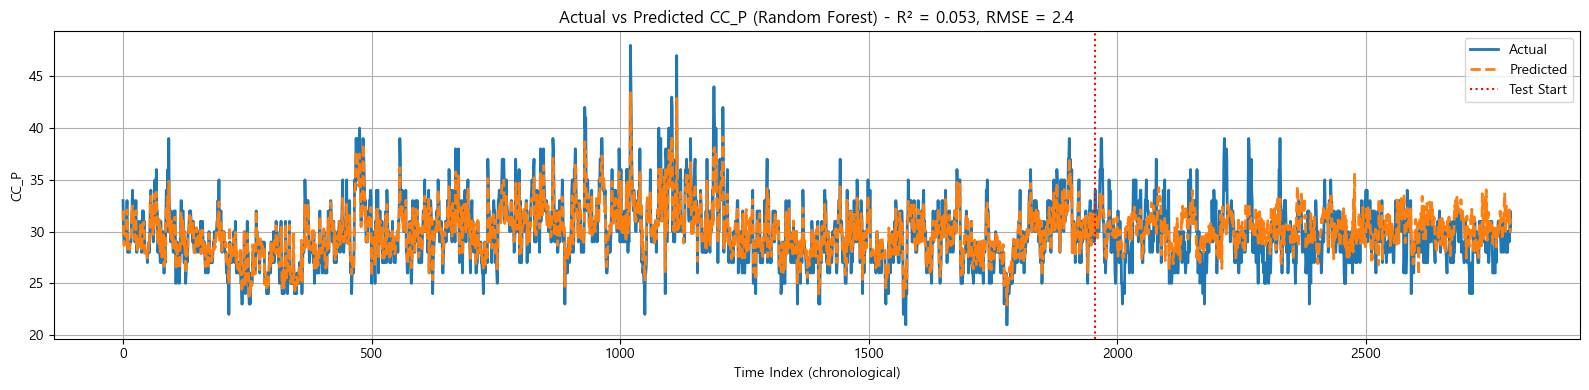

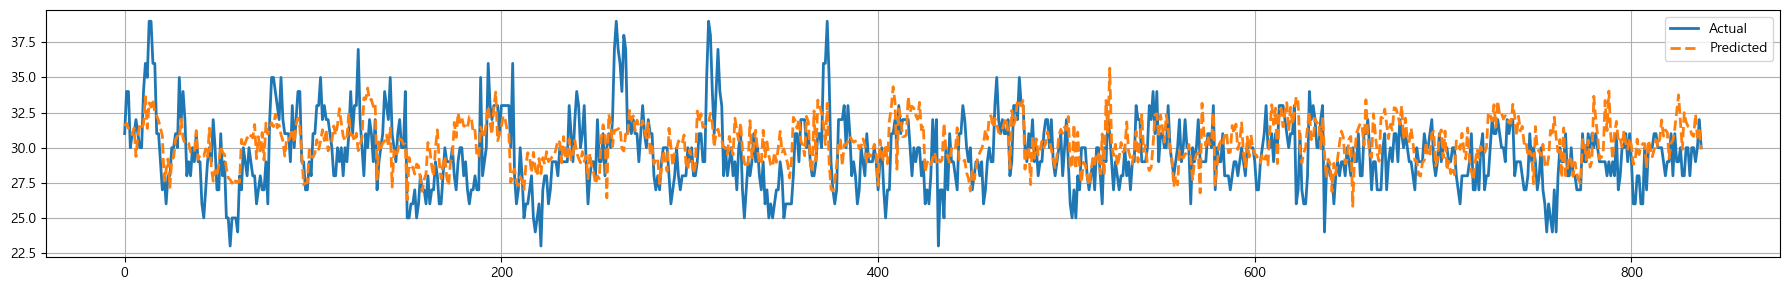

 99%|===================| 1943/1955 [00:46<00:00]        


--- SHAP Summary: Random Forest ---


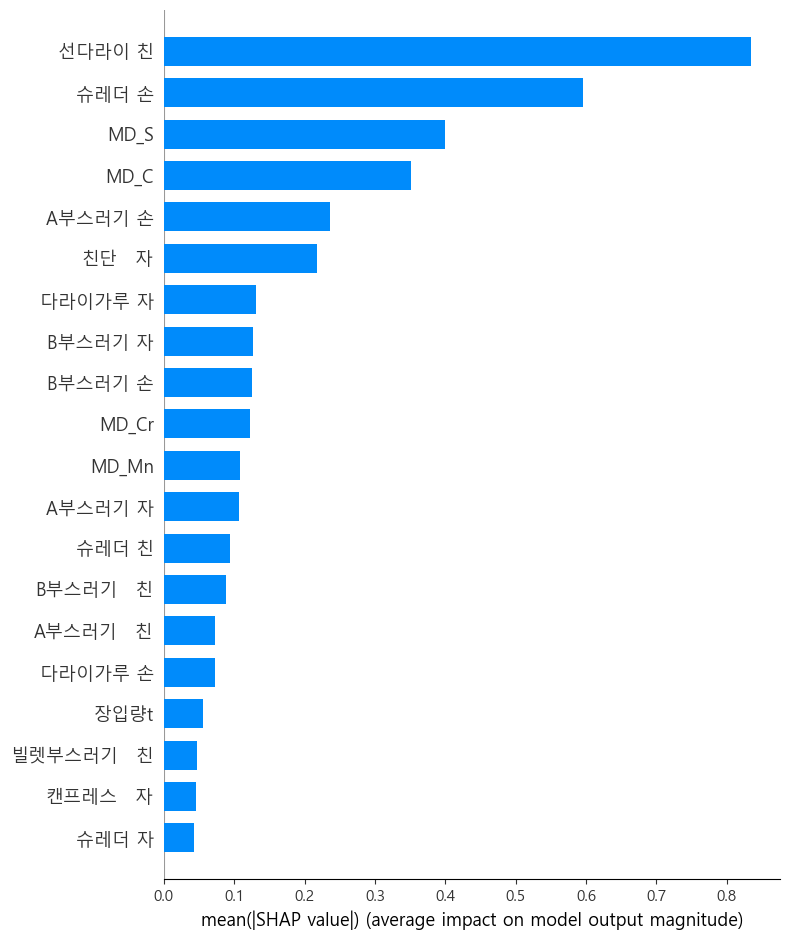

In [8]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test, df)

# SHAP for Random Forest
explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_train)

# Global importance plot
print("\n--- SHAP Summary: Random Forest ---")
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")